In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 4

import sys;import os;
module_path = os.path.abspath(os.path.join('..')).split('PythonCode')[0]+'PythonCode'
if module_path not in sys.path: sys.path.append(module_path+"/")
    
import Plib.ML.Models as ml
import Plib.Signals.TAnalysis as ta
import Plib.Signals.Filters as flt
import pickle

import warnings
warnings.filterwarnings("ignore")

#Intel(R) Extension for Scikit-learn dynamically patches scikit-learn estimators to use oneDAL as the underlying solver
from sklearnex import patch_sklearn
patch_sklearn()
 

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
fname='goldReg.pickle'
with open(fname, 'rb') as handle:
    data = pickle.load(handle) 

#Aligna data in sdata
min_data=[]
for k in data.keys(): min_data.append(data[k].index.min())
d1=str(max(min_data)) 
max_data=[]
for k in data.keys(): max_data.append(data[k].index.max())
d2=str(min(max_data)) 
sdata={}
for k in data.keys():
    df=data[k]
    df=df[(df.index>=d1) & (df.index<=d2)]
    sdata[k]=df 

### Class definition for strategy

In [3]:
class MLTRNN(ml.RNNC):
                
    @staticmethod
    def fs_generation(df,l_rets=[3,15,30],w_sma=[3,15,60],drop_nan=True):
        d1=ta.getVolumeGap(df)
        d1=ta.getDailyChange(d1)
        d1=ta.getOpenSpread(d1)
        d1=ta.getLaggedRets(d1,periods=l_rets)
        d1=ta.getSMAs(d1,periods=w_sma)
        d1=ta.getMarketUpDown(d1)
        d1['H-L'] = d1['High'] - d1['Low']
        d1['O-C'] = d1['Close'] - d1['Open']
        d1['3day MA'] = d1['Close'].shift(1).rolling(window = 3).mean()
        d1['10day MA'] = d1['Close'].shift(1).rolling(window = 10).mean()
        d1['30day MA'] = d1['Close'].shift(1).rolling(window = 30).mean()
        d1['Std_dev']= d1['Close'].rolling(5).std()
        fast=min(w_sma)
        d1=ta.getSMACorr(d1,lbl_sma='sma_'+str(fast))
        nan_index=max(max(w_sma),max(l_rets))
        if drop_nan:
            d1=d1[nan_index:]
            d1=d1.dropna()
        features=[c for c in d1.columns if c not in ['Open','High','Low','Close','Adjusted_close','Volume','MarketUpDown_Close1day']]
        return d1,list(features)
    
    @staticmethod
    def makeStudy(df,features=[],regrnd1='',test_periods=252,split=0.85,table=False):
        df=df[:-test_periods].copy()
        df1 = MLTRNN.scaling(df[[*([regrnd1]+features)]],params={'method':'minmax','exclude':[]})
        
        nparams={'hlayers': 3, 'nnlayers': [512,256,128], 'dropOut':-1, 'earlyStop':False, 
                 'esMetric':'mae', 'batchNorm': -1, 'sAlgo':'mbgd', 'sParam': 100}
        initializer={'sigma':1,'mode':'fan_avg', 'distribution':'uniform'}
        optimizer={'optimizer':'adam', 'loss':'mse','learning_rate' : 0.001, 'metrics':['mae']} 

        stats = MLTRNN.rnnClassifier(df1,regrnd1,t = split,nparams=nparams,
                                     initializer=initializer,optimizer=optimizer,table=table)
        return stats



### Data and plot

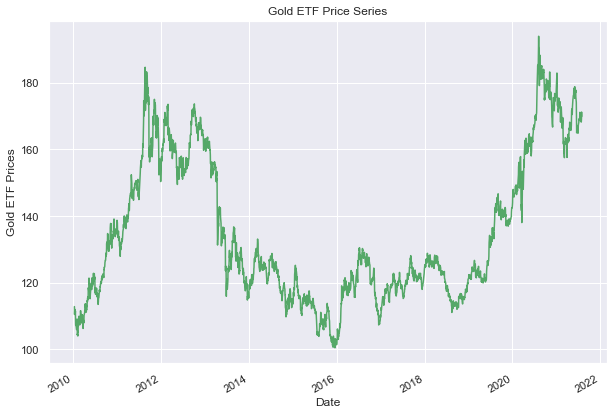

Open    High     Low   Close  Adjusted_close      Volume  \
Date                                                                     
2010-01-11  113.34  113.59  112.52  112.85          112.85  17252989.0   
2010-01-12  112.38  113.05  110.14  110.49          110.49  29182550.0   
2010-01-13  110.92  111.57  109.57  111.54          111.54  20013968.0   

            volumeGap_  dailyChange_   OD_   OL_  ...      sma_15      sma_60  \
Date                                              ...                           
2010-01-11    0.081899     -0.004323  1.82  1.76  ...  108.886000  109.078433   
2010-01-12    0.525586     -0.016818 -0.96 -1.21  ...  108.988667  109.205600   
2010-01-13   -0.377140      0.005590 -1.46 -2.13  ...  109.294667  109.344933   

            MarketUpDown_Close1day   H-L   O-C     3day MA  10day MA  \
Date                                                                   
2010-01-11                      -1  1.07 -0.49  111.233333   109.182   
2010-01-12                       1  2.91 -1.89  111.680000   109.631   
2010-01-13                       1  2.00  0.62  111.570000   109.825   

              30day MA   Std_dev  corr_sma_3  
Date                                          
2010-01-11  111.039767  1.143394    0.873720  
2010-01-12  110.914100  0.905494    0.922250  
2010-01-13  110.761767  0.906438    0.883895  

[3 rows x 26 columns]

In [4]:
# Instantiate Linreg algo
algo=MLTRNN(epochs=50,batch_size=100)

# Select data
gold = sdata['gld_etf']

# Clean data
gold= algo.cleanData(gold)

# Create Features
gold,features=algo.fs_generation(gold)

# Plot the closing price of GLD 11 
gold.Close.plot(figsize=(10, 7),color='g')
plt.ylabel("Gold ETF Prices")
plt.title("Gold ETF Price Series")
plt.show()
gold.head(3)

In [5]:
def algot(gd_test,signal):
    
    gd_test['Signal'] = signal
    # Compute GLD returns 
    gd_test['Ret'] = (gd_test['Close']-gd_test['Close'].shift(1))/gd_test['Close'].shift(1)

    # Compute strategy returns(
    gd_test['Ret1'] = gd_test['Ret']*(gd_test['Signal'].shift(1))
    return gd_test

def plotReturns(df):
    plt.figure(figsize=(10,5))
    plt.plot(((1+df['Ret']).cumprod()),color='r',label='GLD Returns')
    plt.plot(((1+df['Ret1']).cumprod()),color='g',label='Strategy Returns')
    plt.legend()
    plt.show()
    df.head(5)

    

### Test and Diagnostics

In [ ]:
test_periods=252
split=0.8
regrnd1='MarketUpDown_Close1day'
gold_scaled = algo.scaling(gold[[*([regrnd1]+features)]],params={'method':'minmax','exclude':[]})

ret=algo.makeStudy(gold,features,regrnd1,
                        test_periods=test_periods,
                        split=split,table=True)

strategy=algot(gold,algo.getProbs(ret['model'],gold_scaled,features))

plotReturns(strategy)


Instructions for updating:
non-resource variables are not supported in the long term


### Test

Start:  2020-07-30
End:  2021-07-28


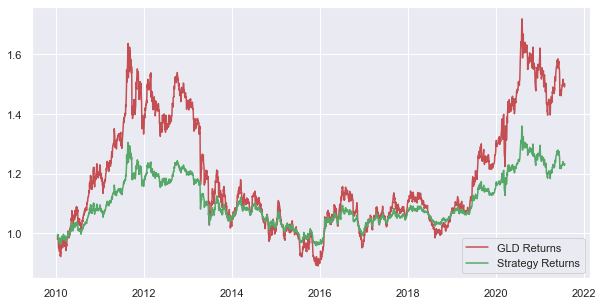

In [7]:
test_periods=252
regrnd1='MarketUpDown_Close1day'

# Strategy data
strategy=gold[:int(len(gold[:-test_periods]))].copy()
gold_scaled = algo.scaling(gold[[*([regrnd1]+features)]],params={'method':'minmax','exclude':[]})
ret=algo.makeStudy(gold,features,regrnd1='MarketUpDown_Close1day',
                            test_periods=test_periods,
                            split=0.75,table=False)

# Test the strategy dy-by-day
print('Start: ', str(strategy.tail(1).index.date[0]))
for d in range(1,test_periods-1):
    last_day=algot(gold[:-test_periods+d],algo.getProbs(ret['model'],gold_scaled[:-test_periods+d],features)).iloc[-1]
    strategy=strategy.append(last_day)
print('End: ', str(strategy.tail(1).index.date[0]))

plotReturns(strategy)


### Features Selection

In [19]:
test_periods=252
gold_study=gold[:-test_periods].copy()
features_set=['sma_3','sma_15','sma_60','volumeGap_','dailyChange_','OD_','OL_',
 'lagRets_3','lagRets_15','lagRets_30','corr_sma_3']+['H-L','O-C','3day MA','10day MA','30day MA','Std_dev']

d1,d2=algo.fs_analysis(gold_study[[*features]])


Features with Lowest Variance volumeGap_ dailyChange_ OD_ OL_ fractHigh_ fractLow_ lagRets_3 sma_15 H-L O-C 3day MA 10day MA 30day MA Std_dev corr_sma_3 LowVar 
 
 count 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 
 
 mean 
 0.000000 
 0.000000 
 0.000100 
 -0.001700 
 0.000000 
 0.000000 
 0.000200 
 0.408200 
 0.003800 
 0.000000 
 0.408600 
 0.408300 
 0.407700 
 0.003300 
 0.002500 
 
 
 std 
 0.001500 
 0.000000 
 0.004000 
 0.003500 
 0.000000 
 0.000000 
 0.005200 
 0.003100 
 0.002400 
 0.002700 
 0.005700 
 0.003600 
 0.005700 
 0.002200 
 0.000600 
 
 
 min 
 -0.005900 
 -0.000100 
 -0.034200 
 -0.034800 
 0.000000 
 0.000000 
 -0.034900 
 0.394400 
 0.000700 
 -0.021500 
 0.374700 
 0.388800 
 0.388200 
 0.000200 
 -0.001100 
 
 
 25% 
 -0.001000 
 -0.000000 
 -0.002000 
 -0.003300 
 0.000000 
 0.000000 
 -0.002800 
 0.406500 
 0.002200 
 -0.001200 
 0.405200 
 0.406300 
 0.403900 
 0.001900 
 0.002100 
 
 
 50% 
 -0.000100 
 0.000000 
 0.000100 
 -0.001400 
 0.000000 
 0.000000 
 0.000200 
 0.408200 
 0.003200 
 0.000000 
 0.408700 
 0.408400 
 0.407900 
 0.002800 
 0.002500 
 
 
 75% 
 0.000900 
 0.000000 
 0.002300 
 0.000200 
 0.000000 
 0.000000 
 0.003300 
 0.410100 
 0.004500 
 0.001200 
 0.412400 
 0.410600 
 0.411100 
 0.004200 
 0.003000 
 
 
 max 
 0.005800 
 0.000200 
 0.030100 
 0.018800 
 0.000200 
 0.000100 
 0.030900 
 0.419200 
 0.023200 
 0.021100 
 0.429800 
 0.421100 
 0.429500 
 0.026200 
 0.003800 
 
            Features with Lowest Correlation volumeGap_ dailyChange_ OD_ lagRets_3 lagRets_15 sma_3 Std_dev corr_sma_3 
 
 count 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 
 
 mean 
 0.000000 
 0.000000 
 0.027000 
 0.071200 
 0.338900 
 131.085700 
 1.086800 
 0.775500 
 
 
 std 
 0.467400 
 0.006600 
 1.358800 
 1.692900 
 3.718100 
 18.592500 
 0.811400 
 0.168200 
 
 
 min 
 -1.642900 
 -0.051400 
 -12.650000 
 -12.895500 
 -15.414800 
 101.576700 
 0.070400 
 -0.308800 
 
 
 25% 
 -0.322400 
 -0.003000 
 -0.620000 
 -0.888100 
 -1.895200 
 117.734200 
 0.582200 
 0.682600 
 
 
 50% 
 -0.025000 
 0.000000 
 0.040000 
 0.080700 
 0.294100 
 124.583300 
 0.896000 
 0.815300 
 
 
 75% 
 0.295200 
 0.003000 
 0.710000 
 1.024600 
 2.674200 
 142.509200 
 1.353700 
 0.908500 
 
 
 max 
 1.719000 
 0.053400 
 10.825000 
 11.127200 
 17.036500 
 184.213300 
 9.502400 
 0.995900

In [9]:
test_periods=252
gold_study=gold[:-test_periods].copy()
regrnd1='MarketUpDown_Close1day'

min_features=['sma_3','sma_15','sma_60',]
add_features=['volumeGap_','dailyChange_','OD_','OL_']#,
 #'lagRets_3','lagRets_15','lagRets_30','corr_sma_3']#+['H-L','O-C','3day MA','10day MA','30day MA','Std_dev']

model=algo.rnnClassifier

nparams={'hlayers': 6, 'nnlayers': [128,128,128,128,128,128], 'dropOut':1, 'earlyStop':True, 
        'esMetric':'mae', 'batchNorm': 4, 'sAlgo':'mbgd', 'sParam': 100}
initializer={'sigma':1,'mode':'fan_avg', 'distribution':'uniform'}
optimizer={'optimizer':'adam', 'loss':'mse','learning_rate' : 0.0015, 'metrics':['mae']}
params=[nparams,initializer,optimizer,False]

df=algo.scaling(gold_study[[*([regrnd1]+min_features+add_features)]],params={'method':'minmax','exclude':[]})
features_comb=algo.fs_combin(df,min_features,regrnd1,add_features,model,params)
print(features_comb)

['sma_3', 'sma_15', 'sma_60', 'volumeGap_', 'OD_', 'OL_']


### Model Parameters

Best Solution:  0 ('MarketUpDown_Close1day', 1, {'hlayers': 3, 'nnlayers': [128, 128, 128], 'dropOut': 1, 'earlyStop': True, 'esMetric': 'mae', 'batchNorm': 4, 'sAlgo': 'mbgd', 'sParam': 100}, {'sigma': 1, 'mode': 'fan_avg', 'distribution': 'uniform'}, {'optimizer': 'adam', 'loss': 'mse', 'learning_rate': 0.0015, 'metrics': ['mae']}, False)


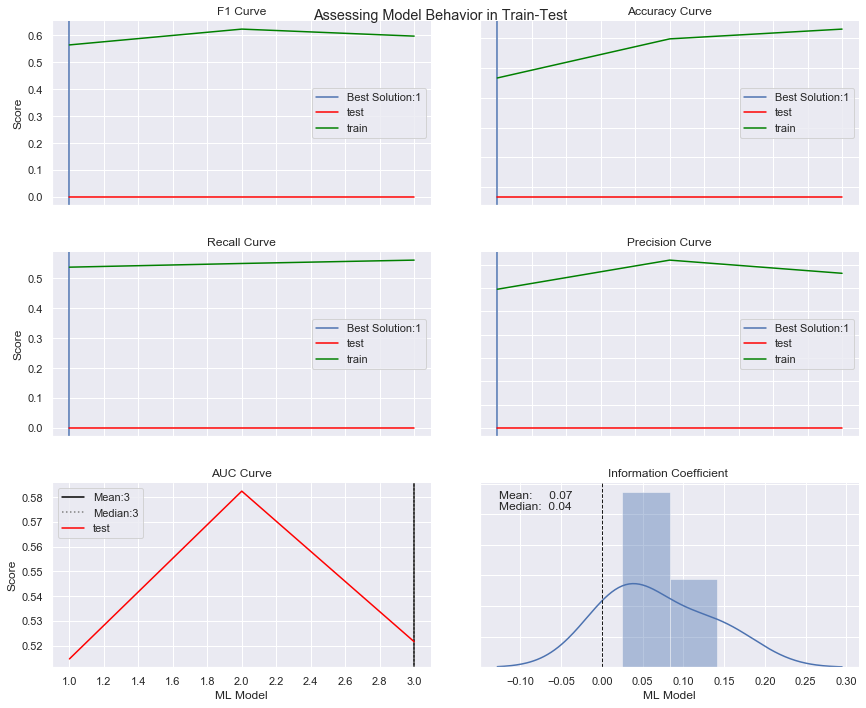

In [20]:
regrnd1='MarketUpDown_Close1day'
model=algo.rnnClassifier
df=algo.scaling(gold_study[[*([regrnd1]+features_set)]],params={'method':'minmax','exclude':[]})

options={'dropOut':1, 'earlyStop':True,'esMetric':'mae', 'batchNorm': 4, 'sAlgo':'mbgd', 'sParam': 100}
params=algo.make_params(regrnd1,nparmz=False, initz=False,optz=False, options=options)
score=algo.md_htDiag(df,regrnd1,model,params,how='awf',Nproc=0)
best_param=algo.md_htDiagPlot(score,(12,10))
print('Best Solution: ',best_param, params[best_param])

Best Solution:  0 ('MarketUpDown_Close1day', 1, {'hlayers': 3, 'nnlayers': [128, 128, 128], 'dropOut': 1, 'earlyStop': True, 'esMetric': 'mae', 'batchNorm': 4, 'sAlgo': 'mbgd', 'sParam': 100}, {'sigma': 1, 'mode': 'fan_avg', 'distribution': 'uniform'}, {'optimizer': 'adam', 'loss': 'mse', 'learning_rate': 0.0015, 'metrics': ['mae']}, False)


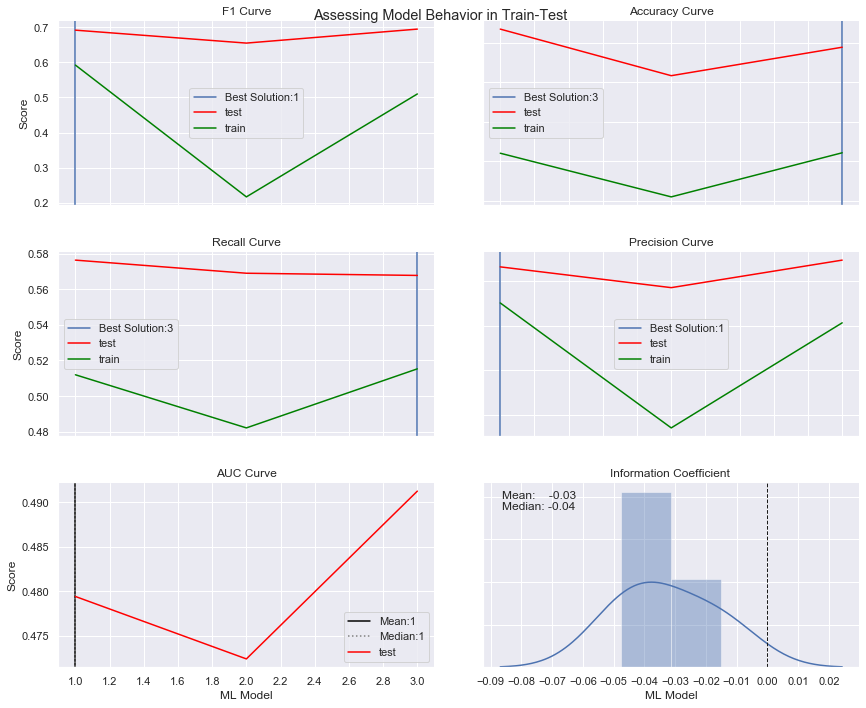

In [22]:
regrnd1='MarketUpDown_Close1day'
model=algo.rnnClassifier
df=algo.scaling(gold_study[[*([regrnd1]+features_set)]],params={'method':'minmax','exclude':[]})

options={'dropOut':1, 'earlyStop':True,'esMetric':'mae', 'batchNorm': 4, 'sAlgo':'mbgd', 'sParam': 100}
params=algo.make_params(regrnd1,nparmz=False, initz=False,optz=False, options=options)
score=algo.md_htDiag(df,regrnd1,model,params,how='cv',Nproc=0)
best_param=algo.md_htDiagPlot(score,(12,10))
print('Best Solution: ',best_param, params[best_param])

### Interpretability and Feature Importance with LIME

Explanation Score:  0.7082282772931474


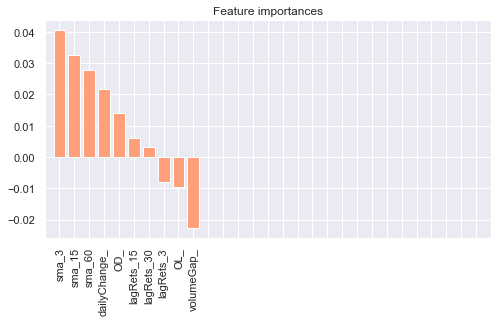

imp
sma_3         0.040547
sma_15        0.032654
sma_60        0.027865
dailyChange_  0.021786
OD_           0.013982
lagRets_15    0.006196
lagRets_30    0.003145
lagRets_3    -0.007881
OL_          -0.009464
volumeGap_   -0.022677

In [11]:
mymodel=ret['model']

lime_gold=algo.scaling(gold,params={'method':'minmax','exclude':[]})

MLTRNN.fs_localInt(lime_gold, features_set, regrnd1,
                   nclasses=['Up','Down'],
                   which_obs=11,model=mymodel)


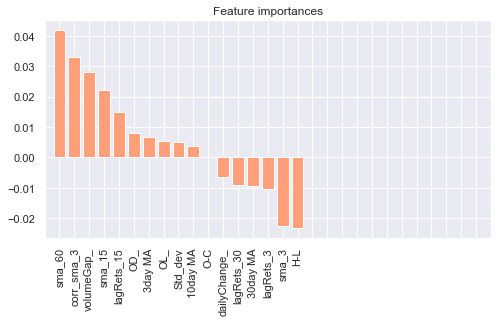

imp
sma_60        0.041775
corr_sma_3    0.032846
volumeGap_    0.028031
sma_15        0.022140
lagRets_15    0.014960
OD_           0.008095
3day MA       0.006709
OL_           0.005240
Std_dev       0.005179
10day MA      0.003693
O-C           0.000210
dailyChange_ -0.006449
lagRets_30   -0.009049
30day MA     -0.009525
lagRets_3    -0.010316
sma_3        -0.022441
H-L          -0.023163

In [12]:
MLTRNN.fs_globalInt(lime_gold, features_set, regrnd1,
                  nclasses=['Up','Down'],ninsta=11, model=mymodel, 
                  mtype='c', test_periods=252)
